## Spatial degs demonstration
This notebook demonstrate:
1. spatial degs  
using Moran'I test to detect the spatial autocorrelation genes.
2. cluster degs  
with cluster and spatial informations, detecting the difference expression genes between two or more clusters.

In [18]:
import spateo as st

# 1. spatial degs

Load data 

In [3]:
import anndata
ipath = "/zfs-1/zuolulu/spatialDEG/test/soybean_root/soybean_A2/A2-root1.h5ad"
adata = anndata.read_h5ad(ipath)

In [3]:
adata

AnnData object with n_obs × n_vars = 2735 × 15163
    obs: 'area', 'slice', 'n_genes', 'n_counts'
    obsm: 'spatial'

First, we do moran'I test to detect the spatial autocorrelation genes to perform feature selection (in addition to the conventional highly variable genes), then followed by PCA and umap dimension reduction.

In [ ]:
m = st.tl.spatial_degs.moran_i(adata)

Then, we filter genes with pvals>0.05 and qvals>0.05

In [11]:
m_filter = m[(m.moran_p_val < 0.05)&(m.moran_q_val<0.05)].sort_values(by=['moran_i'],ascending=False)
#m_filter.to_csv("/zfs-1/zuolulu/spatialDEG/test/soybean_root/soybean_A2/m_filter.csv")
#import pandas as pd
#m_filter = pd.read_csv("/zfs-1/zuolulu/spatialDEG/test/soybean_root/soybean_A2/m_filter.csv",index_col=0)

In [12]:
m_filter

,moran_i,moran_p_val,moran_q_val,moran_z
gene_short_name,,,,
SoyZH13_06G102600,1.0,0.016,0.043855,-1.113308
SoyZH13_06G092801,1.0,0.003,0.011977,-1.060063
SoyZH13_03G123900,1.0,0.001,0.005130,-1.277636
SoyZH13_13G149100,1.0,0.001,0.005130,-0.709418
SoyZH13_11G184600,1.0,0.001,0.005130,0.000000
...,...,...,...,...
SoyZH13_01G000022,1.0,0.009,0.028097,0.000000
SoyZH13_06G019400,1.0,0.012,0.035072,2.716273
SoyZH13_17G178800,1.0,0.008,0.025673,1.002736


We use the sc.pl.scatter to visualize our result instead, due to the bug in st.pl.scatter.

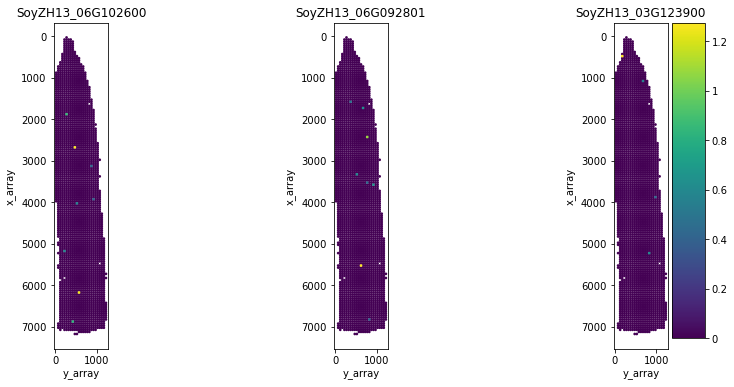

In [79]:
import scanpy as sc
import matplotlib.colors as clr
import matplotlib.pyplot as plt
adata.obs['x_array'] = adata.obsm['spatial'][:,0]
adata.obs['y_array'] = adata.obsm['spatial'][:,1]
genes = m_filter.index.values[0:3]
fig, ax = plt.subplots(1,3,figsize=(15,6),gridspec_kw={'wspace':0.01,'hspace':0.4})
axes = ax.flatten()
for i,g in enumerate(genes):
    axes[i] = sc.pl.scatter(adata,alpha=1,x="y_array",y="x_array",color=g,title=g,ax=axes[i],show=False,size=80000/adata.shape[0])
    axes[i].set_aspect('equal', 'box')
    axes[i].axes.invert_yaxis()
fig.axes[-1].remove()
fig.axes[-2].remove()

# 2 cluster degs

Load data

In [10]:
ipath = "/zfs-1/zuolulu/spatialDEG/test/soybean_root/soybean_A2/A2-root1-group.h5ad"
adata = anndata.read_h5ad(ipath)
adata

AnnData object with n_obs × n_vars = 2735 × 15163
    obs: 'area', 'slice', 'n_genes', 'n_counts', 'group'
    obsm: 'spatial'

After cluster. we have an anndata object, which column key/name 'group' identifies the grouping information (for example, clusters that correspond to different cell types) of buckets, adata.obs['group']. Below we plot its domains.

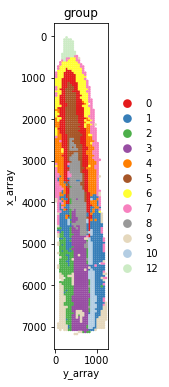

In [98]:
plot_color=["#E41A1C","#377EB8","#4DAF4A", "#984EA3" ,"#FF7F00", "#A65628", "#FFFF33" ,"#F781BF" ,"#999999" ,"#E5D8BD" ,"#B3CDE3" ,"#CCEBC5","#FED9A6", "#FBB4AE", "#8DD3C7" ,"#BEBADA", "#80B1D3", "#B3DE69", "#FCCDE5", "#BC80BD"]
#Plot spatial domains
domains="group"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
adata.obs['x_array'] = adata.obsm['spatial'][:,0]
adata.obs['y_array'] = adata.obsm['spatial'][:,1]
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax = sc.pl.scatter(adata,alpha=1,x="y_array",y="x_array",color=domains,title=domains,ax=ax,color_map=plot_color,show=False,size=80000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

First,given a test group, `test group=5`, we find marker genes between the test group and other groups together `method = 'all'` based on gene expression via Mann-Whitney U test,and we calcute the percentage of buckets expressing the gene in the test group(ratio_expr),the difference between the percentages of buckets expressing the gene in the test group and control groups(diff_ratio_expr),the expression fold change between the test and control groups(log2fc), in addition, qval is calculated using Benjamini-Hochberg.

In [112]:
st.tl.cluster_degs.find_cluster_degs(adata,group='group',test_group=5,control_groups=[0,1,2,3,4,6,7,8,9,10,12],genes=None,method='all')

identifying top markers for each group: 15163it [01:25, 178.29it/s]


,gene,test_group,control_group,ratio_expr,diff_ratio_expr,log2fc,pval,qval
0,SoyZH13_20G131500,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12]",0.356808,0.307640,3.253665,6.925515e-64,1.672512e-60
1,SoyZH13_16G181400,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12]",0.812207,0.476759,1.734009,1.801169e-61,2.174912e-58
2,SoyZH13_10G229500,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12]",0.323944,0.275569,3.051862,2.371098e-53,1.908734e-50
3,SoyZH13_11G245000,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12]",0.967136,0.224472,0.797569,4.769380e-45,2.879513e-42
4,SoyZH13_09G138300,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12]",0.920188,0.336524,1.019472,1.210610e-40,5.847245e-38
...,...,...,...,...,...,...,...,...
545,SoyZH13_11G114600,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12]",0.159624,0.051774,0.673263,1.455344e-02,4.847801e-02
546,SoyZH13_04G174900,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12]",0.276995,0.073585,0.373480,1.460083e-02,4.856886e-02
547,SoyZH13_07G022700,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12]",0.892019,0.076793,0.154718,1.472485e-02,4.891405e-02
548,SoyZH13_04G166000,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12]",0.103286,0.042620,0.720000,1.497162e-02,4.966546e-02


plot the marker genes from `st.tl.cluster_degs.find_cluster_degs(method='all')`

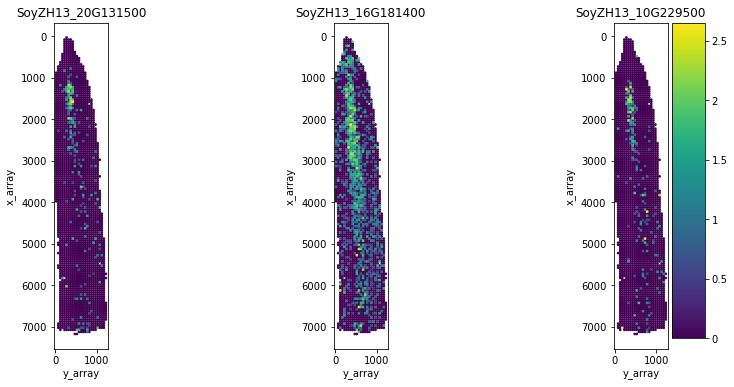

In [14]:
genes = ['SoyZH13_20G131500','SoyZH13_16G181400','SoyZH13_10G229500']
fig, ax = plt.subplots(1,3,figsize=(15,6),gridspec_kw={'wspace':0.01,'hspace':0.4})
axes = ax.flatten()
for i,g in enumerate(genes):
    axes[i] = sc.pl.scatter(adata,alpha=1,x="y_array",y="x_array",color=g,title=g,ax=axes[i],show=False,size=80000/adata.shape[0])
    axes[i].set_aspect('equal', 'box')
    axes[i].axes.invert_yaxis()
fig.axes[-1].remove()
fig.axes[-2].remove()

Then, for the test group, we find marker genes between the test group and other groups one by one `method = 'one'` .

In [113]:
st.tl.cluster_degs.find_cluster_degs(adata,group='group',test_group=5,control_groups=[0,1,2,3,4,6,7,8,9,10,12],genes=None,method='one')

identifying top markers for each group: 15163it [01:54, 132.30it/s]


,gene,test_group,control_group,ratio_expr,diff_ratio_expr,log2fc,pval,qval
0,SoyZH13_09G138300,5,0,0.920188,0.458439,1.719510,1.184002e-51,3.145301e-48
1,SoyZH13_09G138300,5,6,0.920188,0.632309,2.478428,3.092368e-49,5.134297e-46
2,SoyZH13_11G245000,5,0,0.967136,0.267683,1.060615,7.024157e-46,9.820881e-43
3,SoyZH13_16G181400,5,2,0.812207,0.628800,2.941568,1.334273e-45,1.772248e-42
4,SoyZH13_16G181400,5,0,0.812207,0.536250,2.047098,1.564140e-43,1.731308e-40
...,...,...,...,...,...,...,...,...
7253,SoyZH13_17G061500,5,6,0.126761,0.071205,0.606993,1.975453e-02,4.975624e-02
7254,SoyZH13_09G025200,5,12,0.206573,0.148880,0.916194,1.975382e-02,4.975624e-02
7255,SoyZH13_08G212000,5,7,0.807512,0.295434,0.305899,1.979917e-02,4.985449e-02
7256,SoyZH13_05G212300,5,7,0.107981,0.064503,0.451324,1.980856e-02,4.987342e-02


Plot the marker genes from `st.tl.cluster_degs.find_cluster_degs(method='one')`

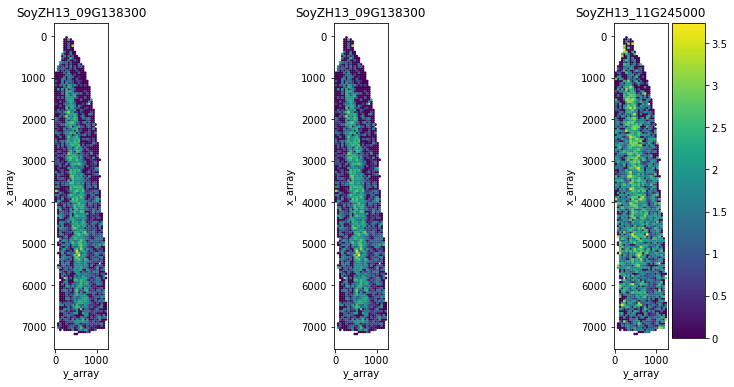

In [15]:
genes = ['SoyZH13_09G138300','SoyZH13_09G138300','SoyZH13_11G245000']
fig, ax = plt.subplots(1,3,figsize=(15,6),gridspec_kw={'wspace':0.01,'hspace':0.4})
axes = ax.flatten()
for i,g in enumerate(genes):
    axes[i] = sc.pl.scatter(adata,alpha=1,x="y_array",y="x_array",color=g,title=g,ax=axes[i],show=False,size=80000/adata.shape[0])
    axes[i].set_aspect('equal', 'box')
    axes[i].axes.invert_yaxis()
fig.axes[-1].remove()
fig.axes[-2].remove()

Second, we find markers for all groups, and return the result in adata object.

In [114]:
adata = st.tl.cluster_degs.find_all_cluster_degs(adata,group='group',genes=None)

identifying top markers for each group: 15163it [01:24, 179.77it/s]
identifying top markers for each group: 15163it [01:24, 178.98it/s]
identifying top markers for each group: 15163it [01:21, 185.98it/s]
identifying top markers for each group: 15163it [01:18, 192.06it/s]
identifying top markers for each group: 15163it [01:26, 176.04it/s]
identifying top markers for each group: 15163it [01:25, 176.73it/s]
identifying top markers for each group: 15163it [01:23, 181.54it/s]
identifying top markers for each group: 15163it [01:14, 203.98it/s]
identifying top markers for each group: 15163it [01:14, 202.18it/s]
identifying top markers for each group: 15163it [01:12, 208.41it/s]
identifying top markers for each group: 15163it [01:26, 175.57it/s]
identifying top markers for each group: 15163it [01:23, 181.40it/s]


Now, we consider the spatial information, given a test group, test group = '5', and then use knn method to search the neighbour groups in spatial space for the test group(test group='5'), do a differential expression analysis result between the test group and neighbor groups.

In [11]:
st.tl.cluster_degs.find_spatial_cluster_degs(test_group=5,adata=adata,x=None,y=None,group='group')

identifying top markers for each group: 15163it [01:24, 179.56it/s]


,gene,test_group,control_group,ratio_expr,diff_ratio_expr,log2fc,pval,qval
0,SoyZH13_09G138300,5,[0],0.920188,0.458439,1.719510,1.184002e-51,2.859365e-48
1,SoyZH13_11G245000,5,[0],0.967136,0.267683,1.060615,7.024157e-46,8.481670e-43
2,SoyZH13_16G181400,5,[0],0.812207,0.536250,2.047098,1.564140e-43,1.259133e-40
3,SoyZH13_18G230000,5,[0],0.849765,0.434465,1.500348,3.736874e-34,2.256138e-31
4,SoyZH13_06G117600,5,[0],0.798122,0.418341,1.495015,4.807923e-30,2.322227e-27
...,...,...,...,...,...,...,...,...
203,SoyZH13_20G061600,5,[0],0.511737,0.131956,0.417626,5.125663e-03,4.795954e-02
204,SoyZH13_01G221300,5,[0],0.131455,0.065882,1.344984,5.143487e-03,4.795954e-02
205,SoyZH13_07G187600,5,[0],0.117371,0.065458,0.987777,5.193897e-03,4.805847e-02
206,SoyZH13_10G010300,5,[0],0.399061,0.114908,0.548014,5.215370e-03,4.807297e-02


Plot the marker genes from `st.tl.cluster_degs.find_spatial_cluster_degs()`

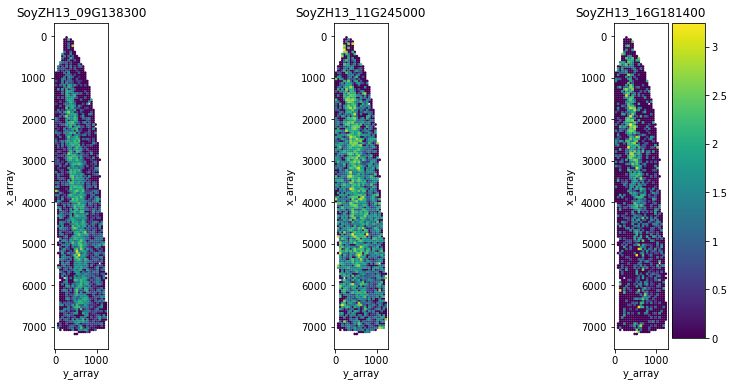

In [17]:
genes = ['SoyZH13_09G138300','SoyZH13_11G245000','SoyZH13_16G181400']
fig, ax = plt.subplots(1,3,figsize=(15,6),gridspec_kw={'wspace':0.01,'hspace':0.4})
axes = ax.flatten()
for i,g in enumerate(genes):
    axes[i] = sc.pl.scatter(adata,alpha=1,x="y_array",y="x_array",color=g,title=g,ax=axes[i],show=False,size=80000/adata.shape[0])
    axes[i].set_aspect('equal', 'box')
    axes[i].axes.invert_yaxis()
fig.axes[-1].remove()
fig.axes[-2].remove()